# Time Series Analysis of Amazons's Stock Price

### Forecasting with an ARIMA model

Previously we used the Long Short-Term Memory (LSTM) network to forecast Amazon's stock prices, however, in this notebook we will have a look at applying a time series model to the stock prices. More specifically, an ARIMA model.

### The  ARIMA (p,d,q) model

ARIMA(p,d,q) forecasting equation: ARIMA models are, in theory, the most general class of models for forecasting a time series which can be made to be “stationary” by differencing (if necessary). A random variable that is a time series is **stationary** if its statistical properties are all constant over time.  A stationary series has no trend, its variations around its mean have a constant amplitude, and its short-term random time patterns always look the same in a statistical sense.  The latter condition means that its autocorrelations (correlations with its own prior deviations from the mean) remain constant over time.  A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component.  An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors.  

The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series.

A **nonseasonal** ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

-**p** is the number of autoregressive terms,

-**d** is the number of nonseasonal differences needed for stationarity

-**q** is the number of lagged forecast errors in the prediction equation.


The first (and most important) step in fitting an ARIMA model is the determination of the order of differencing needed to stationarize the series. Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero, either from above or below. If the series still exhibits a long-term trend, or otherwise lacks a tendency to return to its mean value, or if its autocorrelations are are positive out to a high number of lags (e.g., 10 or more), then it needs a higher order of differencing. 

 ### Stationarity

It is important that the correct number of differences is taken. Taking first differences is usually sufficient to obtain stationarity. In some instances it is necessary to difference twice. A number of testing procedures has been proposed for determining the order of integration. We will consider the Dickey-Fuller (DF) test, proposed by Dickey and Fuller (1979).

The null and alternative hypothesis of the DF test are 

H(null): d = 1

H(alt): d = 0

Hence, the null hypothesis that series is non-stationary (has a unit-root) is tested aganst the alternative hypothesis that the series is stationary (no unit root). 

### ACF and PACF Plots

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.  By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed. The ACF plot is merely a bar chart of the coefficients of correlation between a time series and lags of itself. The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding an AR term to the model. **The lag at which the PACF cuts off is the indicated number of AR terms.**

If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative (overdifferenced) then consider adding an MA term to the model. **The lag at which the ACF cuts off is the indicated number of MA terms.**

### Seasonality

The seasonal difference of a time series is the series of changes from one season to the next. For monthly data, in which there are 12 periods in a season, the seasonal difference of Y at period t is Yt - Yt-12. If the seasonal difference of Y is stationary white noise (independently and identically distributed values with no autocorrelation), then Y is described by a seasonal random walk model: each value is a random step away from the value that occurred exactly one season ago.

Seasonal differencing is a crude form of additive seasonal adjustment: the "index" which is subtracted from each value of the time series is simply the value that was observed in the same season one year earlier. Seasonal differencing therefore usually removes the gross features of seasonality from a series, as well as most of the trend. 

If the series has a strong and consistent seasonal pattern, then you must use an order of seasonal differencing (otherwise the model assumes that the seasonal pattern will fade away over time).

There are different ways to determine the seasonality of a series. The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar: Hour of day, day of month, weekly, monthly and yearly.

When there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.


## Downloading the data 

I will be using Amazon's historic monthly stock price, which can be downloaded at the link: https://finance.yahoo.com/quote/AMZN/history?period1=1391904000&period2=1581206400&interval=1mo&filter=history&frequency=1mo.
Yahoo finance has various other stocks to choose from.

**Import libraries**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")

Now it's time to import the dataset and view it. We do so using the pandas library and its read_csv function.

In [3]:
data = pd.read_csv('/Users/lukabeverin/Downloads/AMZN-5.csv')
#head is used to view the first 5 observations
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-03-01,358.739990,383.109985,330.880005,336.369995,336.369995,75253500
1,2014-04-01,338.089996,348.299988,288.000000,304.130005,304.130005,138278700
2,2014-05-01,304.130005,314.869995,284.380005,312.549988,312.549988,78579200
3,2014-06-01,312.589996,340.720001,303.839996,324.779999,324.779999,76580100
4,2014-07-01,325.859985,364.850006,311.859985,312.989990,312.989990,99426000


We are only interested in the Close price. Also, we need to set the Date as the index for the dataframe. 

In [26]:
df = data[['Date','Close']]
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df.head()

,Close
Date,
2014-03-01,336.369995
2014-04-01,304.130005
2014-05-01,312.549988
2014-06-01,324.779999
2014-07-01,312.989990


Plot Amazon's stock prices

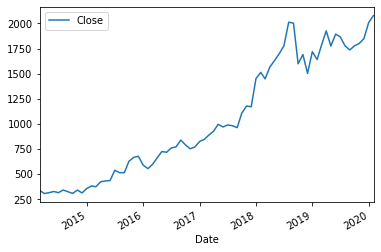

In [7]:
df.plot(style="-")

### Determine number of differences (d) needed for stationarity

Dickey-Fuller (DF) test for stationarity

In [10]:
#Stationary test

results = adfuller(df['Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on Close is: ' + str(results[1]))

if results[1] < 0.05:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

(-0.08665923992248753, 0.9507512192132263, 0, 72, {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}, 727.0372357045036)
The p-value of the test on Close is: 0.9507512192132263
Fail to reject the null hypothesis.


We fail to reject the null hypothesis that the series is non-stationary. We now refer to the ACF to help us determine the number of differences needed to obtain stationarity.

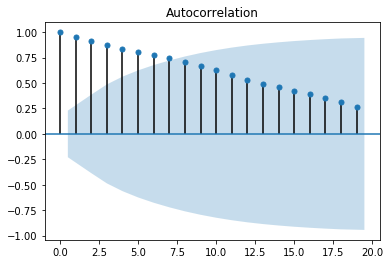

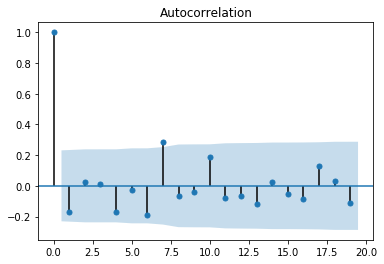

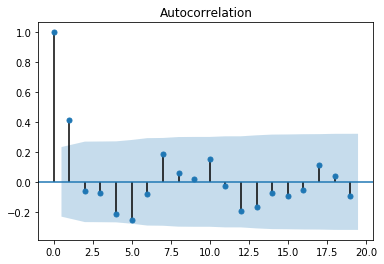

In [11]:
# Original Series
plot_acf(df.dropna())


#1st order difference
plot_acf(df.diff(1).dropna())


#2nd order difference
plot_acf(df.diff(2).dropna())

plt.show()

There is no indication of seasonality in the ACF plots.

Taking the **first difference** seems appropriate in this case due to ACF plot decaying fairly rapidly to zero.

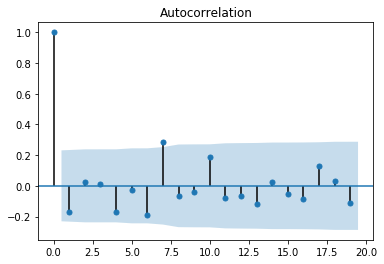

In [12]:
#Setting the differenced time series to df_d (d = differenced)
df_d = df.diff(1)
df_d = df_d.dropna()
plot_acf(df_d)
plt.show()

Once again we check whether the series is stationary by taking the first difference.

In [13]:
#Stationary test
results = adfuller(df_d['Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on Close is: ' + str(results[1]))

if results[1] < 0.05:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

(-9.889788681684546, 3.5832967945419386e-17, 0, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, 714.4355494873729)
The p-value of the test on Close is: 3.5832967945419386e-17
Reject the null hypothesis.


With a very small p-value, we reject the null hypothesis at a 5% significance level and can confidently say that the series is now stationary after taking the **first difference.**

### Determine the number of autoregressive terms (p)

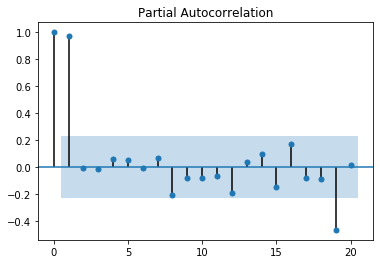

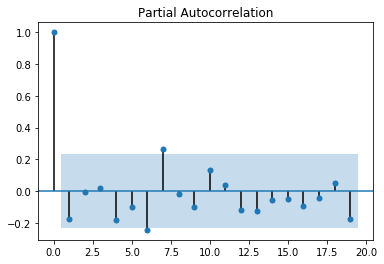

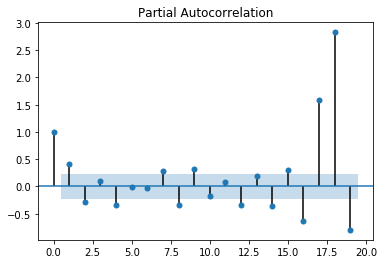

In [14]:
# Original Series
plot_pacf(df.dropna(), lags = 20)


#1st order difference
plot_pacf(df.diff(1).dropna())


#2nd order difference
plot_pacf(df.diff(2).dropna())

plt.show()

Based on the PACF plot of the first difference, we would choose our AR parameter to be equal to 1 because at lag 1 the PACF plot cuts off. In other words, we take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot. 

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. We will compute the BIC as we vary the order, p, in an AR(p) from 0 to 6.

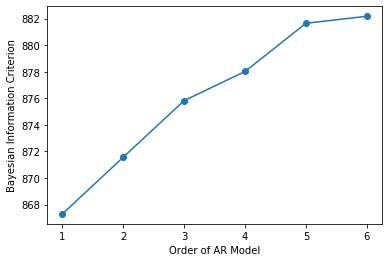

In [20]:
#check AR parameter using BIC -> the lower the BIC the better
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(df_d, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

The BIC and PACF plots indicate the optimal order the AR model is **p = 1**.

### Determine the number of moving average terms (q)

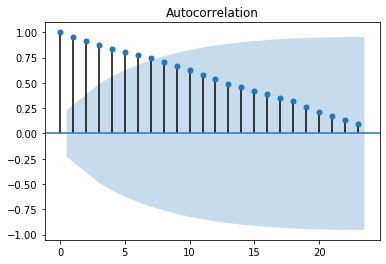

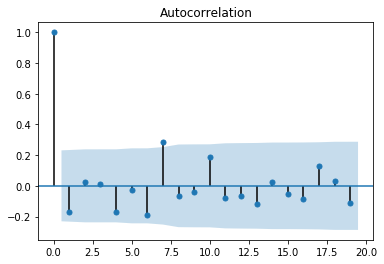

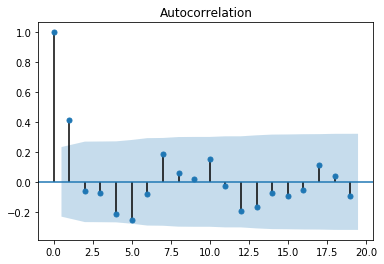

In [21]:
# Original Series
plot_acf(df.dropna(), lags = 23)


#1st order difference
plot_acf(df.diff(1).dropna())


#2nd order difference
plot_acf(df.diff(2).dropna())

plt.show()

Based on the ACF plot of the first difference we would select the MA parameter as q = 1. We take the order of MA term to be equal to as many lags that crosses the significance limit in the ACF plot.

Similarly, we can use the BIC to help us determine the MA parameter. We will compute the BIC as we vary the order, q, in an MA(q) from 0 to 6.

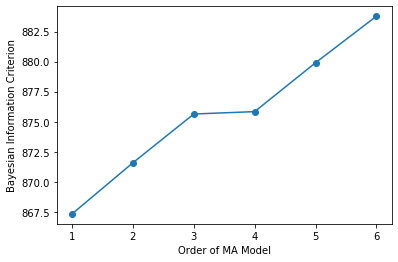

In [22]:
BIC = np.zeros(7)
for q in range(7):
    try:
        mod = ARMA(df_d, order=(0,q))
        res = mod.fit()
# Save BIC for MA(q)    
        BIC[q] = res.bic
    except:
        pass

# Plot the BIC as a function of q
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of MA Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

The BIC and PACF plots indicate the optimal order the MA model is q = 1.

### ARIMA (1,1,1) model

In [34]:
model = ARIMA(df, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -426.253
Method:                       css-mle   S.D. of innovations             88.888
Date:                Mon, 09 Mar 2020   AIC                            860.506
Time:                        17:18:51   BIC                            869.613
Sample:                             1   HQIC                           864.131
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            26.1746      2.528     10.355      0.000      21.220      31.129
ar.L1.D.Close     0.8377      0.074     11.340      0.000       0.693       0.982
ma.L1.D.Close    -1.0000      0.045    -

## Forecast the Next 12 Months

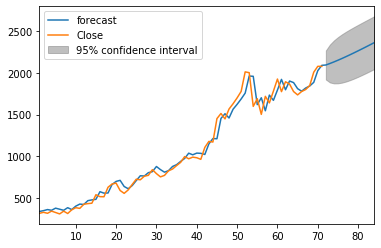

In [36]:
model_fit.plot_predict(start=2, end=len(df)+12)
plt.show()

In [37]:
pred = model_fit.predict(start=2, end=len(df)+12, typ='levels')
pred.tail()

80    2265.640559
81    2289.779509
82    2314.248903
83    2338.995099
84    2363.973165
dtype: float64

### Caveat


A caveat about long-term forecasting in general: linear time series models such as ARIMA and exponential smoothing models predict the more distant future by making a series of one-period-ahead forecasts and plugging them in for unknown future values as they look farther ahead. For example, a 2-period-ahead forecast is computed by treating the 1-period-ahead forecast as if it were data and then applying the same forecasting equation. This step can be repeated any number of times in order to forecast as far into the future as you want, and the method also yields formulas for computing theoretically-appropriate confidence intervals around the longer-term forecasts. However, the models are identified and optimized based on their one-period-ahead forecasting performance, and rigid extrapolation of them may not be the best way to forecast many periods ahead (say, more than one year when working with monthly or quarterly business data), particularly when the modeling assumptions are at best only approximately satisfied (which is nearly always the case). If one of your objectives is to generate long-term forecasts, it would be good to also draw on other sources of information during the model selection process and/or to optimize the parameter estimates for multi-period forecasting if your software allows it and/or use an auxiliary model (possibly one that incorporates expert opinion) for long-term forecasting.

### References

https://people.duke.edu/~rnau/411home.htm

Notebook completed by Luka